# Advection equation without separating space and time with SWIM and ELM (no ODE solver)

In [4]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import AdvectionSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
from scipy.stats import qmc

Problem setup

(25600, 2)


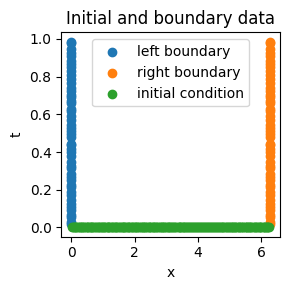

In [5]:
# create equally spaced points in a square
x_lim = [0, 2 * np.pi] # space domain
t_lim = [0, 1] # time domain
rng = np.random.default_rng(seed=123)

# initial condition
def u0(x):
    return np.sin(x)

# boundary condition: Loss term that tries to satisfy the solution and it's first derivative zero at the boundary
boundary_condition = "periodic strict" 

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# Boundary and initial data
n_initial = 200 # No. of initial points where solution is known
n_boundary = 200 # No. of boundary points where solution is known
rng = np.random.default_rng(seed=123)
n_edges = 4 # edges of the domain
pps = int(n_boundary/n_edges) # points per surface 

# Initial data
x_0 = qmc.LatinHypercube(d=1, seed=221).random(n=n_initial)
x_0 = qmc.scale(x_0, 0, 2 * np.pi)
X_init = np.hstack((x_0, np.zeros_like(x_0)))
u_init = u0(x_0)
data_init = np.column_stack((X_init, u_init.reshape(-1, 1)))

# Boundary data
y_0 = qmc.LatinHypercube(d=1, seed=3).random(n=pps)
y_0 = qmc.scale(y_0, 0, 1)
X_left = np.hstack((np.zeros_like(y_0), y_0))
X_right = np.hstack((np.ones((np.shape(y_0))) * 2 * np.pi, y_0))

# Visualiza initial and boundary data
fig, ax = plt.subplots(1,1,figsize=(3, 3))
ax.scatter(X_left[:, 0], X_left[:, 1], label='left boundary')
ax.scatter(X_right[:, 0], X_right[:, 1], label='right boundary')
ax.scatter(X_init[:, 0], X_init[:, 1], label='initial condition')
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Initial and boundary data")
ax.legend()
fig.tight_layout()

# Test data : 
n_test_space = 256
n_test_time = 100
x_test = np.linspace(x_lim[0], x_lim[1], n_test_space)
t_test = np.linspace(t_lim[0], t_lim[1], n_test_time)
xx_test, yy_test = np.meshgrid(x_test, t_test)
X_test = np.hstack((xx_test.reshape(-1, 1), yy_test.reshape(-1, 1))) # Uniform test points
print(np.shape(X_test))

# coordinates of boundary points (excluding corners)
boundary_points = np.row_stack([X_left, X_right])

# Analytical solution of the PDE
def analytical_sol(x, t, c):
    return np.sin(x - c * t)


In [6]:
# Hyper-parameter run
conv_coeffs = [1e-2, 1e-1, 1, 1e1, 40, 100] # Values of convection coefficients
n_s = 1000 # No. of collocation points
n_s_2 = 8000 # No. of collocation points for beta = 40, 100
ratio = 2 # data points/width
reg = 1e-10 # regularization constants
seeds = [1, 2, 3] # random seeds

experiments = []
for conv_coeff in conv_coeffs:
    # Ground truth for the selected convection coefficient
    u_true_test = analytical_sol(xx_test, yy_test, conv_coeff).reshape(-1, 1)

    # Collocation points
    if conv_coeff < 5:
        n_c = n_s
    else:
        n_c = n_s_2

    # Collocation points
    n_train = int(np.sqrt(n_c))
    sampler_2d_m = qmc.LatinHypercube(d=2, seed=3)
    xy_space_train = sampler_2d_m.random(n=n_train)
    xy_space_scaled_train = qmc.scale(xy_space_train, [0, 0], [2 * np.pi, 1])
    xx_train, yy_train = np.meshgrid(xy_space_scaled_train[:, 0], xy_space_scaled_train[:, 1])
    X_train = np.hstack((xx_train.reshape(-1, 1), yy_train.reshape(-1, 1))) # Uniform test points
    print(np.shape(X_train))
    
    # interior points
    interior_points = X_train
    
    # Domain
    domain = Domain(
        interior_points=interior_points,
        boundary_points=boundary_points,
    )
    # Loop over hyper-params
    info = []
    info.append(conv_coeff)
    info.append(n_c)
    n_b = int(n_c//ratio)
    info.append(n_b)
    info.append(reg)

    # Loop over different seeds
    rmse_swim = np.ones((len(seeds), ))
    rmse_elm = np.ones((len(seeds), ))
    rel_err_swim = np.ones((len(seeds), ))
    rel_err_elm = np.ones((len(seeds), ))
    time_swim = np.ones((len(seeds), ))
    time_elm = np.ones((len(seeds), ))
    j = 0
    for s in seeds:
        ansatz_elm = BasicAnsatz(
            activation='tanh',
            n_neurons=n_b,
            random_state=s,
            regularization_scale=reg,
            parameter_sampler="random"
        )
        ansatz_swim = BasicAnsatz(
            activation='tanh',
            n_neurons=n_b,
            random_state=s,
            regularization_scale=reg,
            parameter_sampler="tanh"
        )
        adv_solver_elm = AdvectionSolver(
            domain=domain, 
            ansatz=ansatz_elm,
            boundary_condition=boundary_condition,
            c=conv_coeff,
            forcing=forcing,
            regularization_scale=reg,
            u0=u0
        )
        adv_solver_swim = AdvectionSolver(
            domain=domain, 
            ansatz=ansatz_swim,
            boundary_condition=boundary_condition,
            c=conv_coeff,
            forcing=forcing,
            regularization_scale=reg,
            u0=u0
        )
        # ELM (No-ODE)
        t_elm_start = time.time()
        adv_solver_elm.fit_no_ode_periodic_bc(data_init=data_init, svd_cutoff = 1e-12); #, num_components=min(1000, int(n_b//2) - 1)
        t_elm_stop = time.time()
        time_elm[s-1] = t_elm_stop - t_elm_start

        # SWIM (No-ODE)
        t_swim_start = time.time()
        adv_solver_swim.fit_no_ode_periodic_bc(data_init=data_init, svd_cutoff = 1e-12); #, num_components=min(1000, int(n_b//2) - 1)
        t_swim_stop = time.time()
        time_swim[s-1] = t_swim_stop - t_swim_start
        
        # Evaluate on test data
        u_swim_test = adv_solver_swim.evaluate_no_ode(X_test).T
        u_elm_test = adv_solver_elm.evaluate_no_ode(X_test).T
        
        # Compute metrics
        rmse_elm[j] = np.sqrt(mean_squared_error(u_true_test, u_elm_test))
        rmse_swim[j] = np.sqrt(mean_squared_error(u_true_test, u_swim_test))  # mean squared error
        rel_err_elm[j] = rmse_elm[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
        rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
        j += 1

    info.append(np.mean(time_elm))
    info.append(np.mean(time_swim))
    info.append(np.mean(rmse_elm))
    info.append(np.std(rmse_elm))
    info.append(np.mean(rmse_swim))
    info.append(np.std(rmse_swim))
    info.append(np.mean(rel_err_elm))
    info.append(np.std(rel_err_elm))
    info.append(np.mean(rel_err_swim))
    info.append(np.std(rel_err_swim))

    print(info)
    experiments.append(info)            


(961, 2)
[0.01, 1000, 500, 1e-10, 0.7666193644205729, 0.7719058195749918, 7.624150780823968e-05, 4.958232324972673e-05, 2.533663166931941e-07, 1.1182647115067283e-07, 0.00010803296854460549, 7.025734041722731e-05, 3.5901592332648247e-07, 1.584562791000999e-07]
(961, 2)
[0.1, 1000, 500, 1e-10, 1.1939496994018555, 1.0760585467020671, 7.20710394114307e-05, 2.86644068485884e-05, 1.1904987125384789e-07, 1.813983796960685e-08, 0.00010212215755486992, 4.061646808918038e-05, 1.686895292250245e-07, 2.5703519836543283e-08]
(961, 2)
[1, 1000, 500, 1e-10, 0.8708645502726237, 0.8127375443776449, 0.00022621065728965715, 0.0001380509307775816, 8.216252732364676e-06, 3.1343416111720854e-06, 0.0003201936050946522, 0.0001954064664413457, 1.162983041676931e-05, 4.436555519107532e-06]
(7921, 2)
[10.0, 8000, 4000, 1e-10, 72.8531699180603, 101.7482848962148, 0.00026008312715635357, 0.0001003575986889398, 0.005460748863210299, 0.0007137372016488022, 0.0003678505030980984, 0.00014194151528042226, 0.0077234507

(6, 14)
Information for beta = 40:
time_swim =  105.98912612597148 time_elm =  74.22406665484111
rmse elm =  3.7884228219570804 +- 0.21024570034196285
rmse swim =  6.8134694354427054 +- 0.2693349524411097
rel error elm =  5.357563860134977 +- 0.29732815444263766
rel error swim =  9.635565860783336 +- 0.38089180518773946


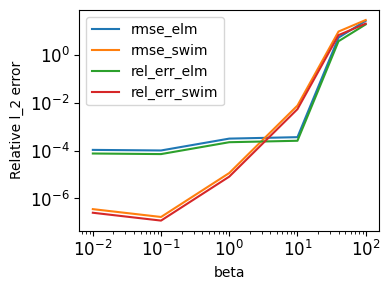

In [18]:
# Convergence plots
fontsize = 12
res = np.vstack(experiments)

# For beta = 40 
print('Information for beta = 40:')
print('time_swim = ', res[-2, -9], 'time_elm = ', res[-2, -10])
print('rmse elm = ', res[-2, -8], '+-', res[-2, -7])
print('rmse swim = ', res[-2, -6], '+-', res[-2, -5])
print('rel error elm = ', res[-2, -4], '+-', res[-2, -3])
print('rel error swim = ', res[-2, -2], '+-', res[-2, -1])

# Extract errors
conv_coeffs = np.reshape(np.asarray(conv_coeffs), (-1, 1))
rmse_elm = np.reshape(res[:, -4], (-1, 1))
rmse_swim = np.reshape(res[:, -2], (-1, 1))
rel_l2_elm = np.reshape(res[:, -8], (-1, 1))
rel_l2_swim = np.reshape(res[:, -6], (-1, 1))

# Store the errors for different values of beta
rmse = np.hstack((conv_coeffs, rmse_elm, rmse_swim))
rel_l2 = np.hstack((conv_coeffs, rel_l2_elm, rel_l2_swim))

# Store rmse error values for convergence plots
with open('adv_swim_elm_rmse.npy', 'wb') as f:
    np.save(f, rmse)

# Store rel l2 error values for convergence plots
with open('adv_swim_elm_rel_l2.npy', 'wb') as f:
    np.save(f, rel_l2)

# Visualiza errors vs convection coefficient
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.loglog(conv_coeffs, res[:, -4], label='rmse_elm')
ax.loglog(conv_coeffs, res[:, -2], label='rmse_swim')
ax.loglog(conv_coeffs, res[:, -8], label='rel_err_elm')
ax.loglog(conv_coeffs, res[:, -6], label='rel_err_swim')
plt.xlabel('beta')
plt.ylabel('Relative l_2 error')
plt.tick_params(axis='both', labelsize=fontsize)
ax.legend()
fig.tight_layout()
plt.savefig('advection_swim_elm.pdf', bbox_inches='tight')
